# 03. Atlas Application and ROI Definition

This notebook loads the LC atlas, defines a reference region, and visualizes both on registered data.

## Atlas Choice

We use the **Ye et al. (2021) 7T probabilistic LC atlas** because:
- Derived from 7T data (matches our target field strength)
- Probabilistic (allows thresholding flexibility)
- Publicly available on NITRC

Alternative: Keren et al. (2009) 3T atlas—we may compare both for sensitivity analysis.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.datasets import load_mni152_template

from src.config import DEFAULT_CONFIG
from src.io import load_nifti, ensure_output_dirs, list_processed_subjects
from src.roi import load_or_create_reference_roi, threshold_probabilistic_atlas
from src.visualization import plot_roi_overlay

In [2]:
# Configuration
config = DEFAULT_CONFIG
ensure_output_dirs(config)

print(f"Atlas directory: {config.atlas_dir}")
print(f"LC atlas file: {config.lc_atlas_filename}")
print(f"LC probability threshold: {config.lc_probability_threshold}")

Atlas directory: /storage/ice1/0/1/byu321/7T-LC-Quantification/atlases/ye_2021/LC_7T_prob
LC atlas file: LCTMP_n53_5SD_prob0.nii.gz
LC probability threshold: 0.1


## 1. Load LC Atlas

Download from: https://www.nitrc.org/projects/lc_7t_prob

In [3]:
import os

# List available atlas files
print("Available atlas files:")
if config.atlas_dir.exists():
    for f in os.listdir(config.atlas_dir):
        if f.endswith('.nii.gz') or f.endswith('.nii'):
            print(f"  {f}")
else:
    print("  Atlas directory does not exist yet.")

Available atlas files:
  mni_icbm152_t1_tal_nlin_asym_09b_hires_FSL_bbox_struc_brain_CSFin.nii
  LCTMP_n53_5SD_prob25.nii.gz
  LCTMP_n53_5SD_prob0.nii.gz
  pontine_reference_MNI.nii.gz
  LCTMP_n53_5SD_prob5.nii.gz


In [4]:
# Load LC atlas
lc_atlas_path = config.lc_atlas_path

if lc_atlas_path.exists():
    lc_atlas_img = load_nifti(lc_atlas_path)
    lc_atlas_data = lc_atlas_img.get_fdata()
    
    print(f"LC Atlas loaded: {config.lc_atlas_filename}")
    print(f"  Shape: {lc_atlas_data.shape}")
    print(f"  Affine:\n{lc_atlas_img.affine}")
    print(f"  Value range: [{lc_atlas_data.min():.3f}, {lc_atlas_data.max():.3f}]")
    print(f"  Non-zero voxels: {np.sum(lc_atlas_data > 0)}")
else:
    raise FileNotFoundError(
        f"LC atlas not found at: {lc_atlas_path}\n"
        "Please download from NITRC and place in atlases/ directory."
    )

LC Atlas loaded: LCTMP_n53_5SD_prob0.nii.gz
  Shape: (364, 436, 364)
  Affine:
[[  -0.5   -0.     0.    90. ]
 [  -0.     0.5   -0.  -126. ]
 [   0.     0.     0.5  -72. ]
 [   0.     0.     0.     1. ]]
  Value range: [0.000, 0.868]
  Non-zero voxels: 925


In [9]:
# Full Bounding Box Check
from nilearn.image import coord_transform

indices = np.where(lc_atlas_data > 0)
x_idx, y_idx, z_idx = indices[0], indices[1], indices[2]

def get_mni_range(indices, dim_idx):
    min_i, max_i = indices.min(), indices.max()
    # Transform assumes x,y,z order.
    # Note: affine maps (i,j,k) -> (x,y,z).
    # We need to construct the full coordinate vector.
    # Simple approximation using diagonal if affine is simple, but let's be robust:
    
    # Get center coordinate
    center_idx = int((min_i + max_i)/2)
    return center_idx # Just returning index for now is less useful.
    
# Let's just print the raw indices range and map the CENTERS to MNI
cx = int((x_idx.min() + x_idx.max()) / 2)
cy = int((y_idx.min() + y_idx.max()) / 2)
cz = int((z_idx.min() + z_idx.max()) / 2)

mni_center = coord_transform(cx, cy, cz, lc_atlas_img.affine)
print(f"Center MNI: {mni_center}")

Center MNI: (0.0, -37.5, -23.0)


## 2. Visualize Atlas

Show the LC atlas location in MNI space. The LC is located in the dorsal pons, adjacent to the 4th ventricle.

/tmp/ipykernel_1711541/455604075.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


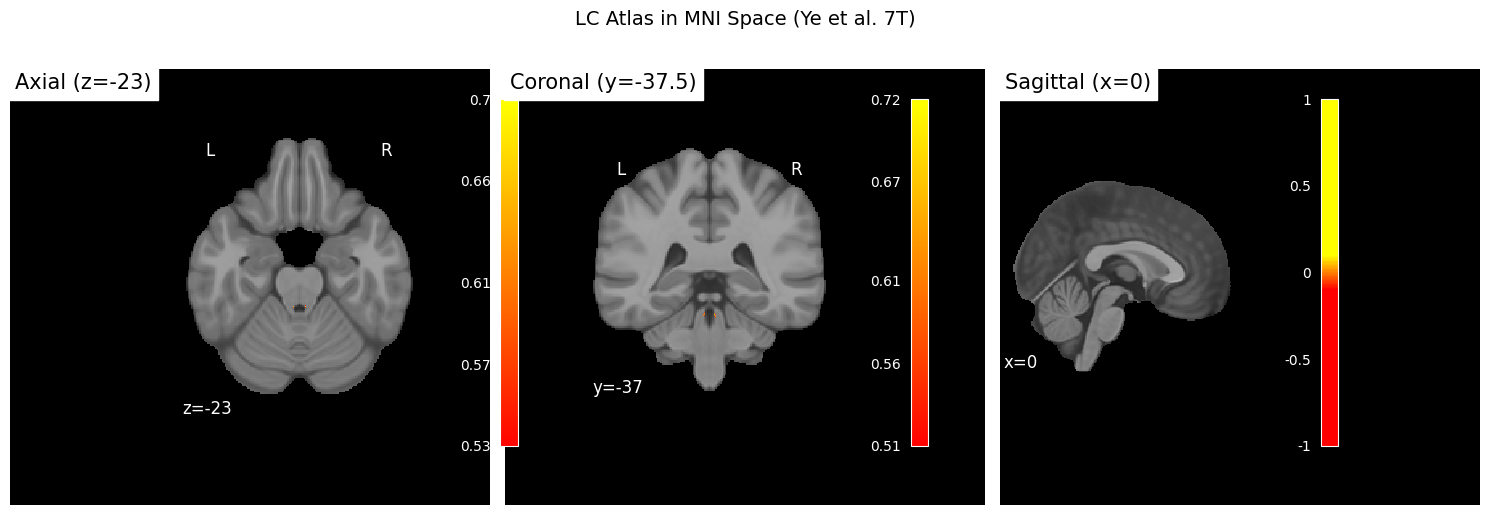

Figure saved: /storage/ice1/0/1/byu321/7T-LC-Quantification/outputs/figures/LC_atlas_MNI.png


In [16]:
# Plot atlas on MNI template
mni_template = load_mni152_template()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# LC is approximately at these MNI coordinates
# x: +/-4-6mm (bilateral), y: -35 to -40mm, z: -25 to -35mm

for i, (display_mode, cut_coords, title) in enumerate([
    ('z', [-23], 'Axial (z=-23)'),
    ('y', [-37.5], 'Coronal (y=-37.5)'),
    ('x', [0], 'Sagittal (x=0)')
]):
    display = plotting.plot_roi(
        lc_atlas_img,
        bg_img=mni_template,
        cut_coords=cut_coords,
        display_mode=display_mode,
        axes=axes[i],
        title=title,
        alpha=0.7,
        cmap='autumn'
    )

plt.suptitle('LC Atlas in MNI Space (Ye et al. 7T)', y=1.02, fontsize=14)
plt.tight_layout()

output_path = config.figures_dir / 'LC_atlas_MNI.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved: {output_path}")

## 3. Create Binary Mask at Different Thresholds

The probabilistic atlas assigns each voxel a probability of being LC. We examine different thresholds.

In [6]:
thresholds = [0.1, 0.25, 0.5, 0.75]

print("LC ROI size at different probability thresholds:")
print("-" * 40)

for thresh in thresholds:
    mask = threshold_probabilistic_atlas(lc_atlas_img, thresh)
    n_voxels = np.sum(mask > 0)
    
    # Estimate volume (depends on voxel size)
    voxel_dims = lc_atlas_img.header.get_zooms()[:3]
    voxel_vol_mm3 = np.prod(voxel_dims)
    volume_mm3 = n_voxels * voxel_vol_mm3
    
    print(f"  Threshold {thresh:.2f}: {n_voxels:4d} voxels ({volume_mm3:.1f} mm^3)")

print("\nNote: Anatomical LC is approximately 2mm x 2mm x 15mm = 60 mm^3")

LC ROI size at different probability thresholds:
----------------------------------------
  Threshold 0.10:  284 voxels (35.5 mm^3)
  Threshold 0.25:  284 voxels (35.5 mm^3)
  Threshold 0.50:   85 voxels (10.6 mm^3)
  Threshold 0.75:    4 voxels (0.5 mm^3)

Note: Anatomical LC is approximately 2mm x 2mm x 15mm = 60 mm^3


## 4. Load or Create Reference Region

For CNR calculation, we need a reference region in the pontine tegmentum adjacent to LC.

The `load_or_create_reference_roi` function will:
1. Load from file if it exists
2. Otherwise, create a geometric sphere at the configured MNI coordinates

In [18]:
# Load or create reference region
ref_img = load_or_create_reference_roi(lc_atlas_img, config)
ref_mask = ref_img.get_fdata()

print(f"Reference region loaded/created")
print(f"  Voxels: {np.sum(ref_mask > 0)}")
print(f"  Center (MNI): {config.reference_center_mni}")
print(f"  Radius: {config.reference_radius_mm} mm")
print(f"  Saved to: {config.reference_roi_path}")

Reference region loaded/created
  Voxels: 925
  Center (MNI): (0.0, -30.0, -28.0)
  Radius: 3.0 mm
  Saved to: /storage/ice1/0/1/byu321/7T-LC-Quantification/atlases/ye_2021/LC_7T_prob/pontine_reference_MNI.nii.gz


/tmp/ipykernel_1711541/2143187278.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


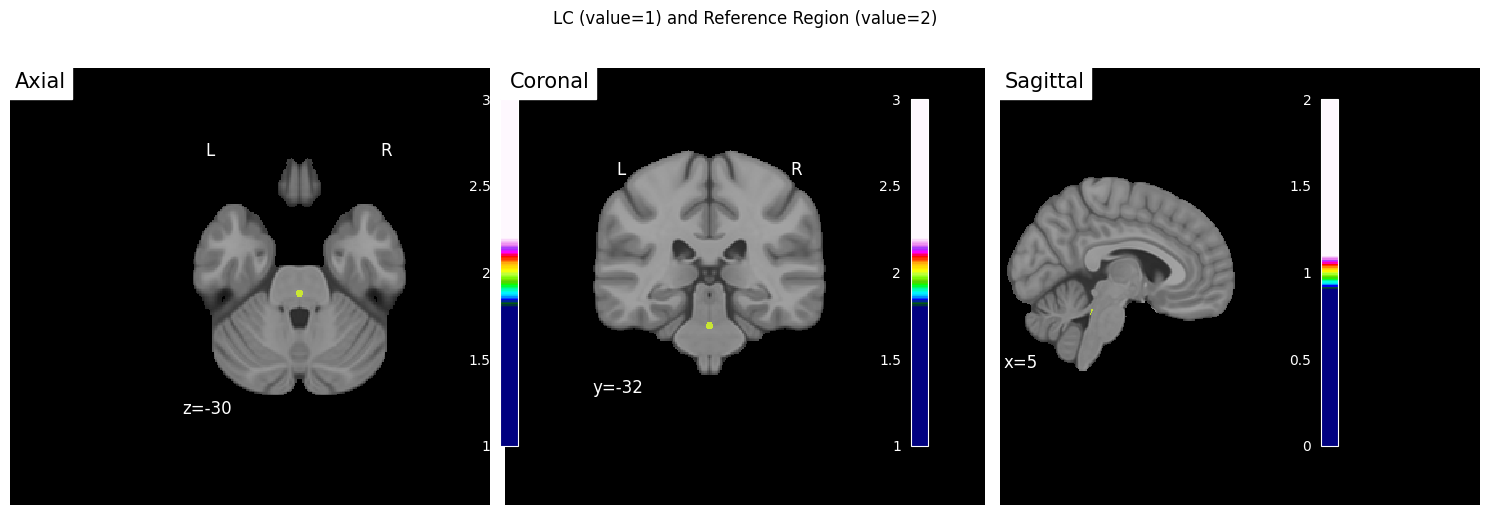

Figure saved: /storage/ice1/0/1/byu321/7T-LC-Quantification/outputs/figures/LC_and_reference_ROIs.png


In [20]:
# Visualize LC and reference together
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Combine LC and reference into one image for visualization
lc_binary = threshold_probabilistic_atlas(lc_atlas_img, config.lc_probability_threshold)
combined = np.zeros_like(lc_atlas_data)
combined[lc_binary > 0] = 1  # LC
combined[ref_mask > 0] = 2   # Reference
combined_img = nib.Nifti1Image(combined, lc_atlas_img.affine)

for i, (display_mode, cut_coords, title) in enumerate([
    ('z', [-30], 'Axial'),
    ('y', [-32], 'Coronal'),
    ('x', [5], 'Sagittal')
]):
    display = plotting.plot_roi(
        combined_img,
        bg_img=mni_template,
        cut_coords=cut_coords,
        display_mode=display_mode,
        axes=axes[i],
        title=title,
        alpha=0.8
    )

plt.suptitle('LC (value=1) and Reference Region (value=2)', y=1.02)
plt.tight_layout()

output_path = config.figures_dir / 'LC_and_reference_ROIs.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved: {output_path}")

## 5. Overlay on Subject Data

Show the LC atlas overlaid on a registered subject's contrast maps.

Available contrasts for sub-0000: ['R2star', 'T1map', 'T2starw', 'T1w', 'R1', 'QSM']


/tmp/ipykernel_1711541/2958169656.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


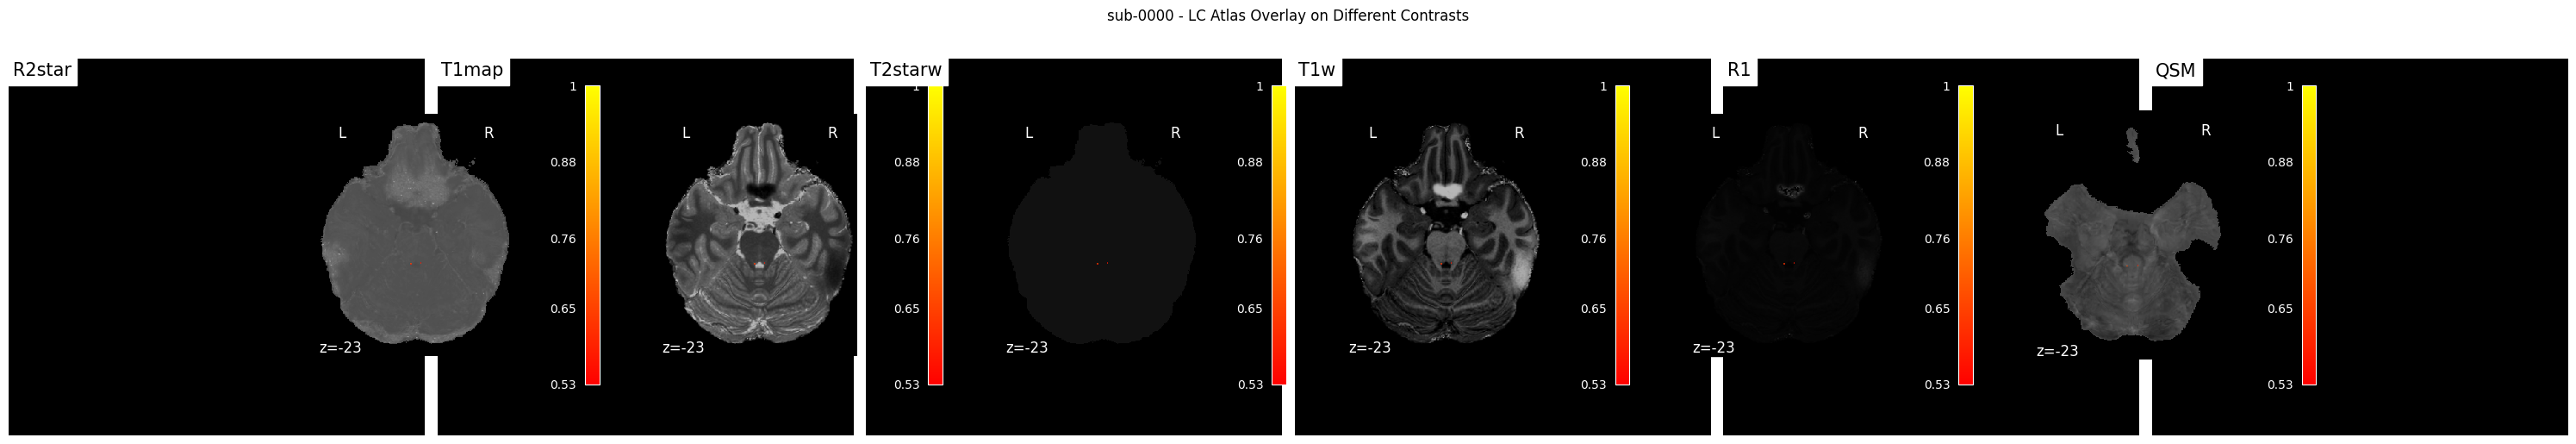

Figure saved: /storage/ice1/0/1/byu321/7T-LC-Quantification/outputs/figures/sub-0000_LC_overlay_all_contrasts.png


In [22]:
# Find processed subjects
processed_subjects = list_processed_subjects(config.output_dir)

if processed_subjects:
    sub_id = processed_subjects[0]
    sub_dir = config.output_dir / sub_id
    
    # Find available contrasts
    contrasts_available = []
    for f in os.listdir(sub_dir):
        if f.endswith('_MNI.nii.gz'):
            contrast = f.replace(f'{sub_id}_', '').replace('_MNI.nii.gz', '')
            contrasts_available.append((contrast, sub_dir / f))
    
    print(f"Available contrasts for {sub_id}: {[c[0] for c in contrasts_available]}")
    
    # Plot LC overlay on each contrast
    n_contrasts = len(contrasts_available)
    if n_contrasts > 0:
        fig, axes = plt.subplots(1, n_contrasts, figsize=(5*n_contrasts, 5))
        if n_contrasts == 1:
            axes = [axes]
        
        for ax, (contrast_name, contrast_path) in zip(axes, contrasts_available):
            contrast_img = load_nifti(contrast_path)
            
            display = plotting.plot_roi(
                lc_atlas_img,
                bg_img=contrast_img,
                cut_coords=[-23],  # Axial at pons
                display_mode='z',
                axes=ax,
                title=contrast_name,
                alpha=0.7,
                vmax=1,
                cmap='autumn'
            )
        
        plt.suptitle(f'{sub_id} - LC Atlas Overlay on Different Contrasts', y=1.02)
        plt.tight_layout()
        
        output_path = config.figures_dir / f'{sub_id}_LC_overlay_all_contrasts.png'
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Figure saved: {output_path}")
else:
    print("No processed subjects found. Run notebook 02 first.")

## 6. Summary

This notebook:
1. Loaded the 7T LC probabilistic atlas
2. Examined ROI size at different probability thresholds
3. Created a pontine tegmentum reference region for CNR calculation
4. Visualized both ROIs on subject data

**Next**: Extract signal from LC region and compute CNR (Notebook 04)